MobileNet

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Params
img_size = 224
batch_size = 32
num_classes = 10

# Paths
train_dir = r"C:\Users\jakub\Desktop\muzyka_guiio\Music-Classification\project_data\train_spectrograms"
test_dir = r"C:\Users\jakub\Desktop\muzyka_guiio\Music-Classification\project_data\test_spectrograms"

# Train/val generators (80/20 split)
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


print("Train:")
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

print("Val:")
val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Test generator (no split)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Test:")
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Train:
Found 640 images belonging to 10 classes.
Val:
Found 159 images belonging to 10 classes.
Test:
Found 200 images belonging to 10 classes.


Most basic version

In [33]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import os




# Model setup
base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)        # Flatten conv output
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# Save model
name_model="mobilenet_music_classifier.keras"
model.save(name_model)
print("Model saved as: ", name_model)

# Test evaluation
print("Testing-------------------------------")
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.2%}")
print(f"Test Loss: {loss:.4f}")


c:\Users\jakub\Desktop\muzyka_guiio\Music-Classification\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 889ms/step - accuracy: 0.1921 - loss: 2.2106 - val_accuracy: 0.4151 - val_loss: 1.8098
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 820ms/step - accuracy: 0.4638 - loss: 1.5842 - val_accuracy: 0.4654 - val_loss: 1.5527
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 891ms/step - accuracy: 0.6096 - loss: 1.2566 - val_accuracy: 0.4969 - val_loss: 1.4590
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 877ms/step - accuracy: 0.6313 - loss: 1.1605 - val_accuracy: 0.5157 - val_loss: 1.4273
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 895ms/step - accuracy: 0.7011 - loss: 1.0079 - val_accuracy: 0.4843 - val_loss: 1.3918
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 946ms/step - accuracy: 0.7190 - loss: 0.9691 - val_accuracy: 0.5031 - val_loss: 1.3699
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 936ms/step - accuracy: 0.7261 - loss: 0.9267 - val_accuracy: 0.5220 - val_loss: 1.3891
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7610 - loss: 0.8445 - val_accurac

Classification report  + Confusion matrix

In [34]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Generujemy predykcje
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Prawdziwe etykiety
y_true = val_generator.classes

# Nazwy klas
class_labels = list(val_generator.class_indices.keys())

# Raport
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step  
              precision    recall  f1-score   support

       blues       0.56      0.62      0.59        16
   classical       0.76      1.00      0.86        16
     country       0.25      0.31      0.28        16
       disco       0.00      0.00      0.00        16
      hiphop       0.82      0.56      0.67        16
        jazz       0.50      0.53      0.52        15
       metal       0.88      0.94      0.91        16
         pop       0.54      0.44      0.48        16
      reggae       0.45      0.62      0.53        16
        rock       0.20      0.25      0.22        16

    accuracy                           0.53       159
   macro avg       0.50      0.53      0.51       159
weighted avg       0.50      0.53      0.51       159



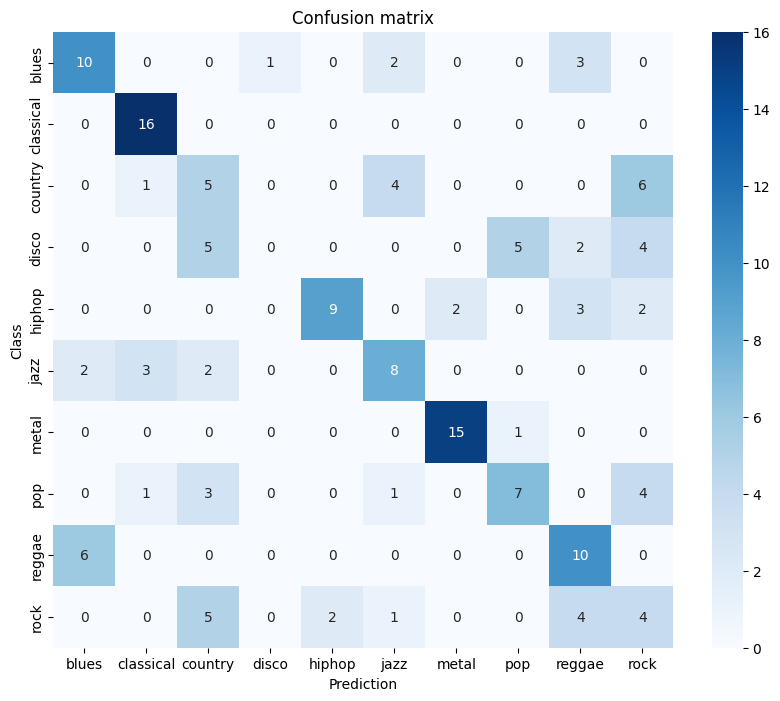

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Prediction")
plt.ylabel("Class")
plt.title("Confusion matrix")
plt.show()

Added dense layer

In [36]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import os


# Model setup
base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)        # Flatten conv output
x = Dense(128, activation='relu')(x)   # Optional dense layer
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# Save model
name_model="mobilenet_music_classifier.keras"
model.save(name_model)
print("Model saved as: ", name_model)

# Test evaluation
print("Testing-------------------------------")
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.2%}")
print(f"Test Loss: {loss:.4f}")


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2467 - loss: 2.0581 - val_accuracy: 0.4591 - val_loss: 1.5069
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 974ms/step - accuracy: 0.5727 - loss: 1.2284 - val_accuracy: 0.4780 - val_loss: 1.4261
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 983ms/step - accuracy: 0.6389 - loss: 1.0266 - val_accuracy: 0.5094 - val_loss: 1.4131
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7288 - loss: 0.8512 - val_accuracy: 0.5094 - val_loss: 1.5092
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7640 - loss: 0.7323 - val_accuracy: 0.5346 - val_loss: 1.3708
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8277 - loss: 0.6021 - val_accuracy: 0.5220 - val_loss: 1.3692
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8392 - loss: 0.5418 - val_accuracy: 0.5409 - val_loss: 1.4144
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8867 - loss: 0.4635 - val_accuracy: 0.5094 - val

In [37]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Generujemy predykcje
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Prawdziwe etykiety
y_true = val_generator.classes

# Nazwy klas
class_labels = list(val_generator.class_indices.keys())

# Raport
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step  
              precision    recall  f1-score   support

       blues       0.54      0.81      0.65        16
   classical       0.73      1.00      0.84        16
     country       0.24      0.31      0.27        16
       disco       0.67      0.25      0.36        16
      hiphop       0.90      0.56      0.69        16
        jazz       0.57      0.53      0.55        15
       metal       0.79      0.94      0.86        16
         pop       0.57      0.25      0.35        16
      reggae       0.48      0.62      0.54        16
        rock       0.20      0.19      0.19        16

    accuracy                           0.55       159
   macro avg       0.57      0.55      0.53       159
weighted avg       0.57      0.55      0.53       159



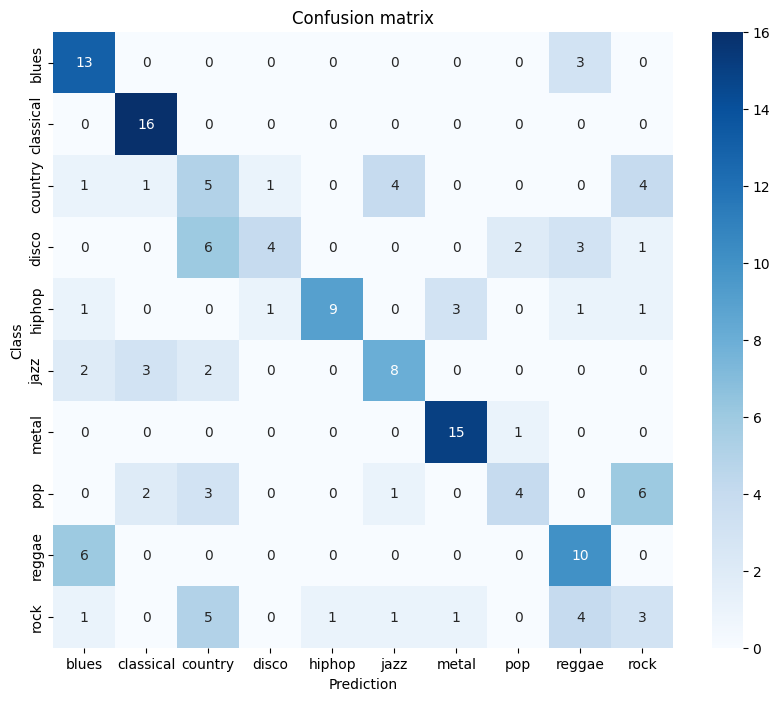

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Prediction")
plt.ylabel("Class")
plt.title("Confusion matrix")
plt.show()